<span style="color:#000000; font-size:1.2em; text-align:right">Data Scientist II Technical Challenge</span>

<span style="color:#e01760; font-size:2em; align=center">Task 2: Predictive Modeling</span>

<font color="#6E6E6E" align="center">Cristina M. Sánchez Maíz | csmaiz@gmail.com | [LinkedIn](https://www.linkedin.com/in/csmaiz/) </font> 

**Tasks:**

Using the cleaned Customer Transactions dataset from Task 1:

- Identify a target variable for prediction (e.g., predicting customer churn, transaction amount).
- Develop a predictive model using an appropriate machine learning algorithm.
- Evaluate the model's performance using relevant metrics (e.g., accuracy,
precision, recall, RMSE). 

**Deliverables:**
- Explanation of the chosen target variable and model.
- Model training and evaluation process.
- Performance metrics and interpretation.

# Import libraries

In [1]:
%matplotlib inline
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import datetime as dt

# Load the dataset

In [2]:
df_orig = pd.read_csv("../output/part1/transactions_cleaned.csv",delimiter=",")
df_orig.head(10)

,customer_id,transaction_id,transaction_date,amount,product_category,payment_method
0,2,1002,2024-04-06,1493.880878,clothing,paypal
1,44,1003,2023-09-22,1323.237903,electronics,debit_card
2,6,1004,2024-01-20,647.237864,clothing,debit_card
3,46,1005,2023-08-28,1385.696166,groceries,debit_card
4,43,1006,2023-08-04,1149.766566,groceries,credit_card
5,18,1007,2024-04-02,728.526325,electronics,debit_card
6,8,1008,2024-02-06,1331.612563,electronics,paypal
7,57,1009,2023-12-13,1293.616488,electronics,debit_card
8,65,1010,2023-10-17,914.013631,electronics,debit_card
9,66,1011,2023-10-31,1011.646799,electronics,debit_card


<div class="alert alert-block alert-warning">
<img src="./images/warning.png" align="left" style="float" width="40">

<b>Comments:</b> 
- "202307" only registered 3 transactions. I discard them.
</div>

In [3]:
# Remove entries of July 2023
df_orig["transaction_date"] = df_orig["transaction_date"].apply(lambda dd: dt.datetime.strptime(dd, "%Y-%m-%d"))
df_orig.drop(df_orig[df_orig["transaction_date"].dt.strftime("%Y%m") == "202307"].index, inplace=True)

# Design the predictive model

The goal is to build a predictive model with the following characteristics:


- Target variable (binary):
    * 1: if the customer will register at least a transaction next month
    * 0: otherwise

- Features: 
    * monthly number of transactions for previous N months.  
    * monthly amount for previous N months. 


Given the amount and the number of transactions in month M, M-1, ...M-N we want to predict for each customer if they are going to make a transaction in month M+1

  M-N ... M-2 M-1  M || M + 1
  




# Feature Engineering 

Build features and target for predictive modeling

Note: I discarded `customer_age` and `customer_income` in Part1 since it does not seem coherent to have more than one customer_age and customer_income for a same customer_id. I won't use this information in this task.


In [4]:
def build_dataset_for_predictions(df, yearmonth, prev_months_depth=5, rolling_depth=3):
    #df["transaction_date"] = df["transaction_date"].apply(lambda dd: dt.datetime.strptime(dd, "%Y-%m-%d"))
    df['yearmonth'] = df['transaction_date'].apply(lambda dd: dd.strftime("%Y%m"))
    df_yearmonth = df.groupby(["yearmonth", "customer_id"])["amount"].agg(["count", "sum"]).reset_index()
    df_yearmonth.rename({"sum" : "amount"}, inplace=True, axis=1)
    
    # Create a complete DataFrame with all possible customer_id-yearmonth combinations 
    # and then joining it with our transaction data.
    customer_ids = df['customer_id'].unique()
    yearmonths = df['yearmonth'].unique()
    index = pd.MultiIndex.from_product([customer_ids, yearmonths], names=['customer_id', 'yearmonth'])
    df_complete = pd.DataFrame(index=index).reset_index()
    
    df_yearmonth = df_complete.merge(df_yearmonth, how='left', on=['customer_id', 'yearmonth'])
    df_yearmonth['amount'] = df_yearmonth['amount'].fillna(0)
    df_yearmonth['count'] = df_yearmonth['count'].fillna(0)
    df_yearmonth['has_transaction'] = np.where(df_yearmonth['amount'] > 0,1, 0)
    df_yearmonth = df_yearmonth.sort_values(["customer_id","yearmonth"])

    df_yearmonth['next_month'] = df_yearmonth.groupby('customer_id')['has_transaction'].shift(-1)

    # Fill missing values with 0 (meaning no transaction in the next month)
    df_yearmonth['next_month'] = df_yearmonth['next_month'].fillna(0)

    # Create the target variable
    df_yearmonth['target'] = df_yearmonth['next_month']

    df_yearmonth['months_with_transactions_past_{}'.format(rolling_depth)] = df_yearmonth.groupby('customer_id')['has_transaction'].rolling(window=rolling_depth).sum().reset_index(level=0, drop=True)


    df_yearmonth=df_yearmonth.fillna(0)
    df_yearmonth = df_yearmonth.drop(["next_month", "has_transaction"], axis=1, errors="ignore")

    for dd in range(1,prev_months_depth+1):
        df_yearmonth['prev_{}_month_transactions'.format(dd)] = df_yearmonth.groupby('customer_id')['count'].shift(dd).fillna(0)
        df_yearmonth['prev_{}_month_amount'.format(dd)] = df_yearmonth.groupby('customer_id')['amount'].shift(dd).fillna(0)
    
    return df_yearmonth[df_yearmonth.yearmonth==yearmonth]

# ML Algorithms

In [5]:


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


def create_datasets(df, prev_months_depth, rolling_depth):
    # Select features and target variable
    X = df[ ["count", "amount"] +
        ['prev_{}_month_transactions'.format(dd) for dd in range(1,prev_months_depth+1)] + 
        ['prev_{}_month_amount'.format(dd) for dd in range(1,prev_months_depth+1)] +
          ['months_with_transactions_past_{}'.format(rolling_depth)]]
    y = df['target']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Feature scaling (optional, but often improves performance)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, X.columns






## Logistic Regression

In [6]:
def run_LR(X_train, y_train, X_test, y_test):
    print (" ------- Building LR model -------")

    # Create a logistic regression model
    model = LogisticRegression()

    # Train the model
    model.fit(X_train, y_train)
    
    print (" ------- LR -------")
    auc, accuracy = evaluate_model(model, X_test, y_test)

    return model, auc, accuracy

## Random Forest

In [7]:
    
def run_RF(X_train, y_train, X_test, y_test, columns_names):
    print (" ------- Building RF model -------")

    # Create a Random Forest classifier
    rf_model = RandomForestClassifier(n_estimators=200, max_depth=5, 
                                      random_state=42, min_samples_split=3,
                                     )

    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Assuming you have a trained model and the training data:
    y_train_pred_proba = rf_model.predict_proba(X_train)[:, 1]
    train_auc = roc_auc_score(y_train, y_train_pred_proba)
    print("AUC on training set:", train_auc)

    
    # Assuming you have a trained Random Forest model named `rf_model`
    importances = rf_model.feature_importances_

    # Create a DataFrame for better visualization
    feature_importances = pd.DataFrame({'feature': columns_names, 'importance': importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
    global_importances = pd.Series(importances, index=columns_names)
    global_importances.sort_values(ascending=True, inplace=True)
    global_importances.plot.barh(color='green')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Global Feature Importance - Built-in Method") 

    auc, accuracy = evaluate_model(rf_model, X_test, y_test)


    return rf_model, auc, accuracy

## XGBoost

In [8]:
def run_xgboost(X_train, y_train, X_test, y_test):

    print (" ------- Building XGBOOST model -------")

    # Create an XGBoost classifier
    model = xgb.XGBClassifier(
        objective='binary:logistic', n_estimators = 200, max_depth=5,  random_state=42, max_bin=2
    )

    # Train the model
    model.fit(X_train, y_train)
    
    y_train_pred_proba = rf_model.predict_proba(X_train)[:, 1]
    train_auc = roc_auc_score(y_train, y_train_pred_proba)
    print("AUC on training set:", train_auc)
    
    auc, accuracy = evaluate_model(model, X_test, y_test)
    return model, auc, accuracy

## Evaluate model

In [9]:
    
def evaluate_model(model, X_test, y_test):
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    print("Accuracy:",  accuracy)
    print("Confusion Matrix:\n", confusion_mat)
    print("Classification Report:\n", classification_rep)

    y_pred_proba = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_pred_proba)
    print("AUC:", auc)
    return auc, accuracy

# Training and testing the model

In [10]:
prev_months_depth=5
rolling_depth=3

yearmonth  = "202403"
df_202403 = build_dataset_for_predictions(df_orig, yearmonth, prev_months_depth=prev_months_depth, rolling_depth=rolling_depth)


yearmonth  = "202404"
df_202404 = build_dataset_for_predictions(df_orig, yearmonth, prev_months_depth=prev_months_depth, rolling_depth=rolling_depth)


yearmonth  = "202405"
df_202405 = build_dataset_for_predictions(df_orig, yearmonth, prev_months_depth=prev_months_depth, rolling_depth=rolling_depth)


df_202404_05 = pd.concat([df_202404, df_202405])

In [11]:
X_train_202403, X_test_202403, y_train_202403, y_test_202403, columns_names = create_datasets(df_202403, prev_months_depth, rolling_depth)

X_train_202404, X_test_202404, y_train_202404, y_test_202404, columns_names = create_datasets(df_202404, prev_months_depth, rolling_depth)
X_train_202405, X_test_202405, y_train_202405, y_test_202405, _ = create_datasets(df_202405, prev_months_depth, rolling_depth)
X_train_202404_05, X_test_202404_05, y_train_202404_05, y_test_202404_05, _ = create_datasets(df_202404_05, prev_months_depth, rolling_depth)


 - - - - - 202403 - - - - - -
 ------- Building LR model -------
 ------- LR -------
Accuracy: 0.43333333333333335
Confusion Matrix:
 [[ 5 13]
 [ 4  8]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.56      0.28      0.37        18
         1.0       0.38      0.67      0.48        12

    accuracy                           0.43        30
   macro avg       0.47      0.47      0.43        30
weighted avg       0.49      0.43      0.42        30

AUC: 0.4814814814814815
 ------- Building RF model -------
AUC on training set: 1.0
Accuracy: 0.5
Confusion Matrix:
 [[ 7 11]
 [ 4  8]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.64      0.39      0.48        18
         1.0       0.42      0.67      0.52        12

    accuracy                           0.50        30
   macro avg       0.53      0.53      0.50        30
weighted avg       0.55      0.50      0.50        30

AUC: 0.35

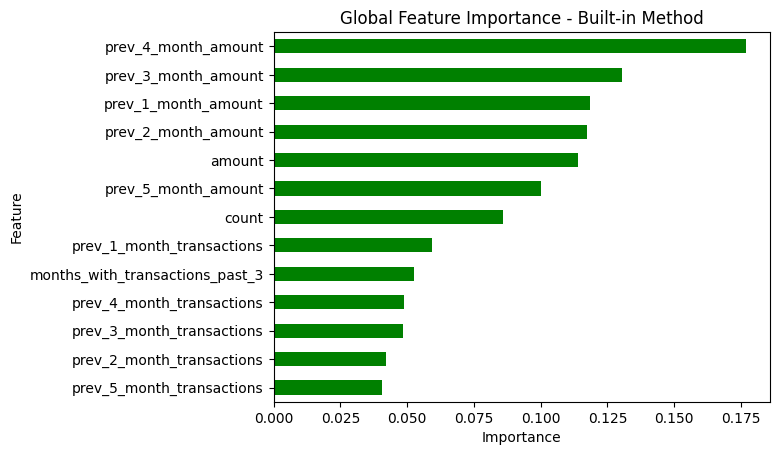

In [12]:
results_auc = {}
results_accuracy = {}


for dataset_label, dataset_ in zip(["202403","202404", "202405", "202404_05"], [ 
    [X_train_202403, X_test_202403, y_train_202403, y_test_202403],
    [X_train_202404, X_test_202404, y_train_202404, y_test_202404],
    [X_train_202405, X_test_202405, y_train_202405, y_test_202405],
    [X_train_202404_05, X_test_202404_05, y_train_202404_05, y_test_202404_05]]):
    print(" - - - - - {} - - - - - -".format(dataset_label))
    X_train, X_test, y_train, y_test = dataset_
    lr_model, auc_lr, accuracy_lr = run_LR(X_train, y_train, X_test, y_test)
    rf_model, auc_rf, accuracy_rf = run_RF(X_train, y_train, X_test, y_test, columns_names)
    xgboost_model, auc_xgboost, accuracy_xgboost = run_xgboost(X_train, y_train, X_test, y_test)
    
    results_auc[dataset_label] = [auc_lr, auc_rf, auc_xgboost]
    results_accuracy[dataset_label] = [accuracy_lr, accuracy_rf, accuracy_xgboost]

In [31]:
# Hago el (3) usando ensamblado por Voting
seed = 7 
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier 


kfold = model_selection.KFold(n_splits=10)
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = RandomForestClassifier(n_estimators=200, max_depth=5, 
                                      random_state=42, min_samples_split=5,
                                     )
estimators.append(('RF', model2))

ensemble_model = VotingClassifier(estimators) # ensemble model
result = model_selection.cross_val_score(ensemble_model, X_train_202405, y_train_202405, cv=kfold) # no necesito la division train/test
print(result.mean()) # 0,867

ens_fitted = ensemble_model.fit(X_train_202405, y_train_202405)



# Make predictions on the test set
y_pred = ens_fitted.predict(X_test_202405)

accuracy = accuracy_score(y_test_202405, y_pred)
confusion_mat = confusion_matrix(y_test_202405, y_pred)
classification_rep = classification_report(y_test_202405, y_pred)

print("Accuracy:",  accuracy)
print("Confusion Matrix:\n", confusion_mat)
print("Classification Report:\n", classification_rep)


auc = roc_auc_score(y_test_202405, y_pred)
print("AUC:", auc)








0.45714285714285713
Accuracy: 0.5333333333333333
Confusion Matrix:
 [[ 6  8]
 [ 6 10]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.50      0.43      0.46        14
         1.0       0.56      0.62      0.59        16

    accuracy                           0.53        30
   macro avg       0.53      0.53      0.52        30
weighted avg       0.53      0.53      0.53        30

AUC: 0.5267857142857143


In [22]:
y_test.shape, y_pred.shape

((60,), (30,))

In [32]:
pd.DataFrame(results_auc, index=["LR", "RF", "XGBOOST"])

,202403,202404,202405,202404_05
LR,0.481481,0.520362,0.379464,0.593333
RF,0.356481,0.547511,0.558036,0.476667
XGBOOST,0.393519,0.710407,0.555804,0.457222


In [33]:
pd.DataFrame(results_accuracy, index=["LR", "RF", "XGBOOST"])

,202403,202404,202405,202404_05
LR,0.433333,0.533333,0.400000,0.516667
RF,0.500000,0.633333,0.666667,0.533333
XGBOOST,0.466667,0.633333,0.566667,0.566667


# Comments on results

Comments

- Poor performance 
- Few data to train the model (80 examples)
- Few data to test the model (20 examples)

Future work

- Hyperparameter Tuning
- Add specific information about each customer 
- Other algorithms